In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.signal import find_peaks
import wfdb

In [2]:
ecg_mit_train = pd.read_csv("mitbih_train.csv",header=None)
ecg_mit_test = pd.read_csv("mitbih_test.csv",header=None)

In [3]:
X_train = ecg_mit_train.iloc[:, :-1]  
y_train = ecg_mit_train.iloc[:, -1]   
X_test = ecg_mit_test.iloc[:, :-1]
y_test = ecg_mit_test.iloc[:, -1]

In [4]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(87554, 187)
(87554,)
(21892, 187)
(21892,)


In [5]:
def plot_class_distribution(df):
    
    unique_classes, counts = np.unique(df, return_counts=True)

    plt.figure(figsize=(8, 5))
    plt.bar(unique_classes, counts, color='skyblue', edgecolor='black')
    plt.xlabel("Class Labels")
    plt.ylabel("Number of Samples")
    plt.title("Class Distribution")
    plt.xticks(unique_classes)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

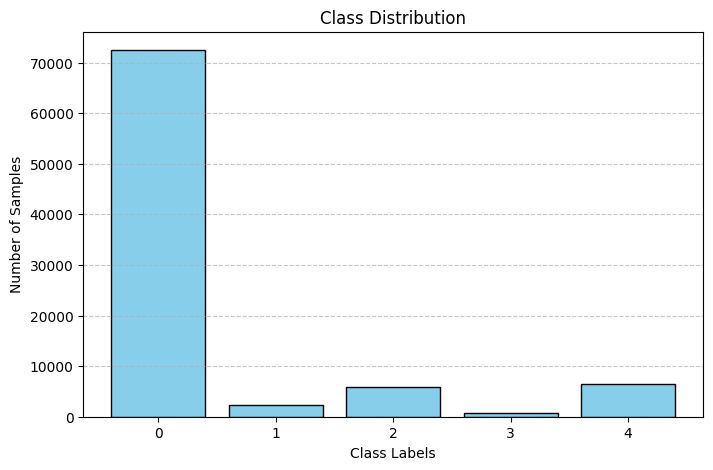

In [6]:
plot_class_distribution(y_train)

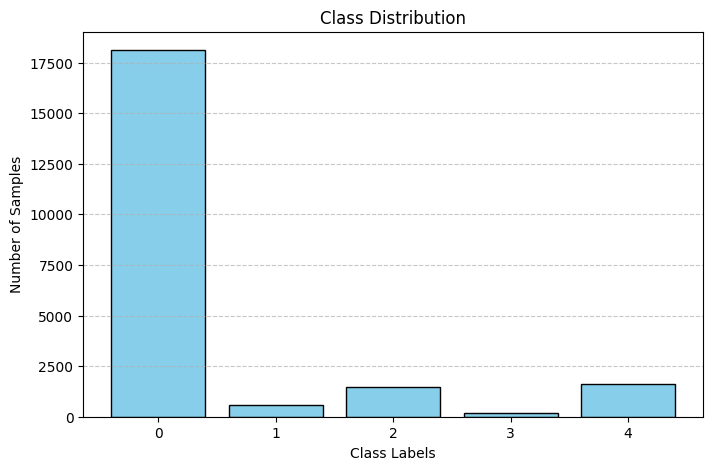

In [7]:
plot_class_distribution(y_test)

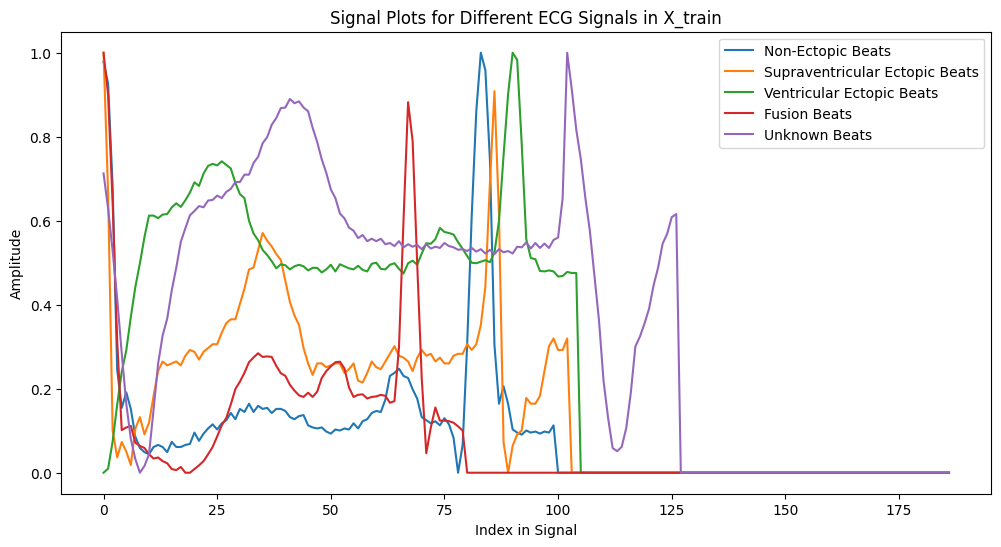

In [9]:
indices = [0, 72471, 74694, 80482, 81123]
labels = ["Non-Ectopic Beats", "Supraventricular Ectopic Beats", 
          "Ventricular Ectopic Beats", "Fusion Beats", "Unknown Beats"]


plt.figure(figsize=(12, 6))


for idx, label in zip(indices, labels):
    plt.plot(X_train.iloc[idx], label=label)

plt.title("Signal Plots for Different ECG Signals in X_train")
plt.xlabel("Index in Signal")
plt.ylabel("Amplitude")
plt.legend()

# Show the plot
plt.show()

In [10]:
import numpy as np
import pandas as pd

def balance_and_augment(X_train, y_train, target_size=30000, shift_range=(0, 10)):
   
    if isinstance(X_train, pd.DataFrame):
        X_train = X_train.values
    if isinstance(y_train, pd.Series):
        y_train = y_train.values

    X_final, y_final = [], []

    for class_label in np.unique(y_train):
        class_indices = np.where(y_train == class_label)[0]
        class_samples = X_train[class_indices]

        if class_label == 0:
            if len(class_samples) > target_size:
                selected_indices = np.random.choice(class_indices, target_size, replace=False)
                class_samples = X_train[selected_indices]
            X_final.append(class_samples)
            y_final.append(np.full(target_size, class_label))
        
        else:
            num_samples = len(class_samples)
            
            if num_samples >= target_size:
                class_samples = class_samples[:target_size]
            else:
                augmented_samples = []
                while len(augmented_samples) + num_samples < target_size:
                    random_index = np.random.choice(range(num_samples))
                    original_sample = class_samples[random_index]

                    
                    shift = np.random.randint(shift_range[0], shift_range[1])
                    augmented_sample = np.roll(original_sample, shift, axis=0) + np.random.normal(0, 0.01, original_sample.shape)

                    augmented_samples.append(augmented_sample)

                if augmented_samples:
                    class_samples = np.vstack([class_samples, np.array(augmented_samples)])[:target_size]

            X_final.append(class_samples)
            y_final.append(np.full(target_size, class_label))

    # Convert lists to NumPy arrays
    X_final = np.concatenate(X_final, axis=0)
    y_final = np.concatenate(y_final, axis=0)

    return X_final, y_final

In [11]:
X_train_balanced, y_train_balanced = balance_and_augment(X_train, y_train, target_size=30000, shift_range=(0, 10))
X_test_balanced, y_test_balanced = balance_and_augment(X_test, y_test, target_size=2000, shift_range=(0, 10))

In [12]:
print(X_train_balanced.shape)
print(y_train_balanced.shape)
print(X_test_balanced.shape)
print(y_test_balanced.shape)

(150000, 187)
(150000,)
(10000, 187)
(10000,)


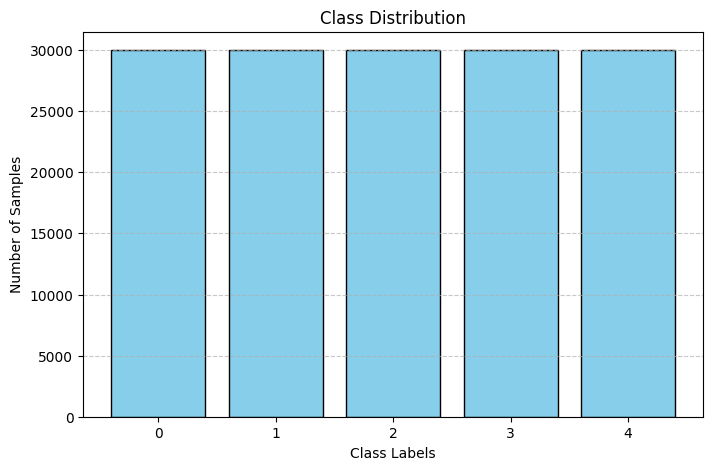

In [13]:
plot_class_distribution(y_train_balanced)

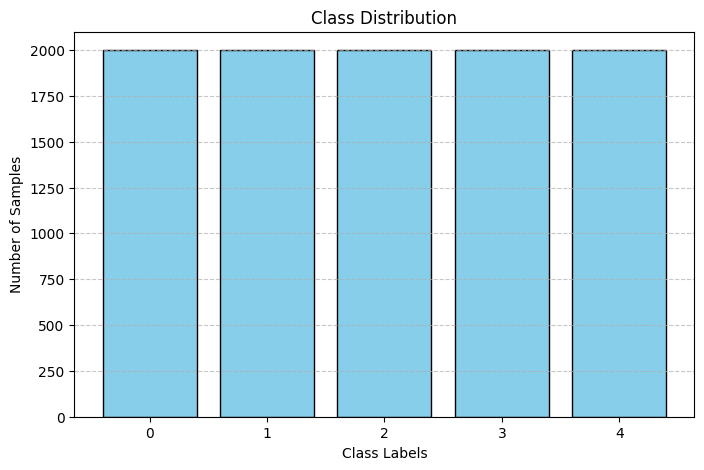

In [14]:
plot_class_distribution(y_test_balanced)

In [15]:
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d

def apply_smoothing(X, window_size=5, window_length=7, polyorder=2, sigma=2):
   
    kernel = np.ones(window_size) / window_size
    X_train_movingaverage = np.apply_along_axis(lambda m: np.convolve(m, kernel, mode='same'), axis=1, arr=X)

    X_train_savitzkygolay = savgol_filter(X, window_length=window_length, polyorder=polyorder, axis=1)

    X_train_gaussian = np.apply_along_axis(lambda m: gaussian_filter1d(m, sigma=sigma), axis=1, arr=X)

    return X_train_movingaverage, X_train_savitzkygolay, X_train_gaussian

In [16]:
X_train_movingaverage, X_train_savitzkygolay, X_train_gaussian = apply_smoothing(X_train_balanced, window_size=5, window_length=7, polyorder=2, sigma=2)

In [17]:
X_test_movingaverage, X_test_savitzkygolay, X_test_gaussian = apply_smoothing(X_test_balanced, window_size=5, window_length=7, polyorder=2, sigma=2)

In [18]:
print(X_train_gaussian.shape)
print(y_train_balanced.shape)
print(X_test_gaussian.shape)
print(y_test_balanced.shape)

(150000, 187)
(150000,)
(10000, 187)
(10000,)


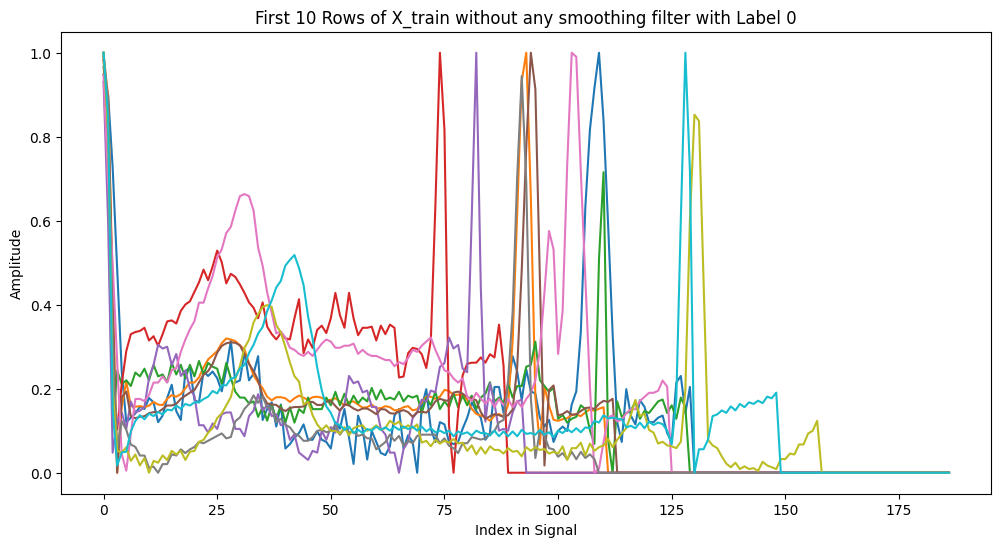

In [48]:
indices_label_0 = np.where(y_train_balanced == 0)[0]  
indices_label_0 = indices_label_0[:10]

plt.figure(figsize=(12, 6))
for idx in indices_label_0:
    plt.plot(X_train_balanced[idx])  

plt.title("First 10 Rows of X_train without any smoothing filter with Label 0")
plt.xlabel("Index in Signal")
plt.ylabel("Amplitude")
plt.show()

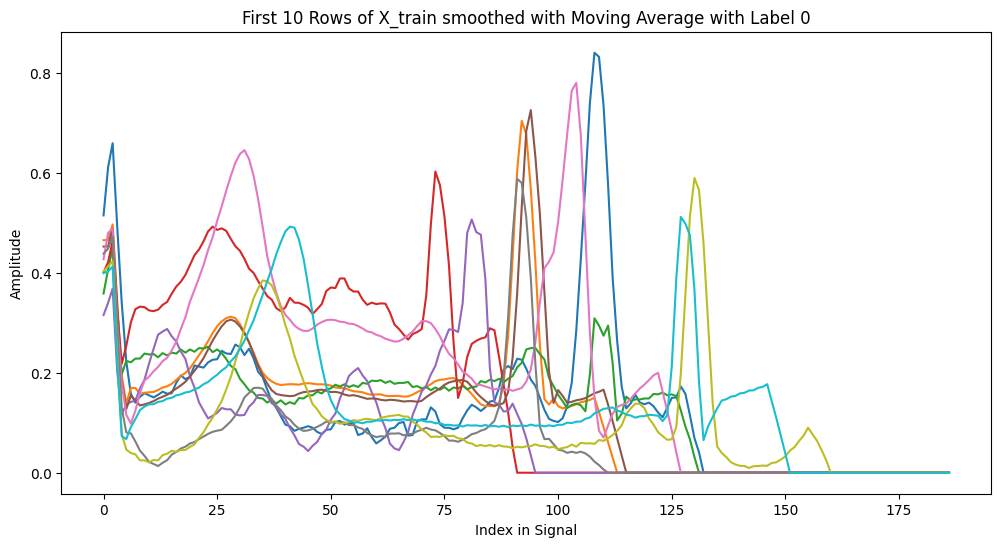

In [47]:
indices_label_0 = np.where(y_train_balanced == 0)[0]  
indices_label_0 = indices_label_0[:10]

plt.figure(figsize=(12, 6))
for idx in indices_label_0:
    plt.plot(X_train_movingaverage[idx])  

plt.title("First 10 Rows of X_train smoothed with Moving Average with Label 0")
plt.xlabel("Index in Signal")
plt.ylabel("Amplitude")
plt.show()

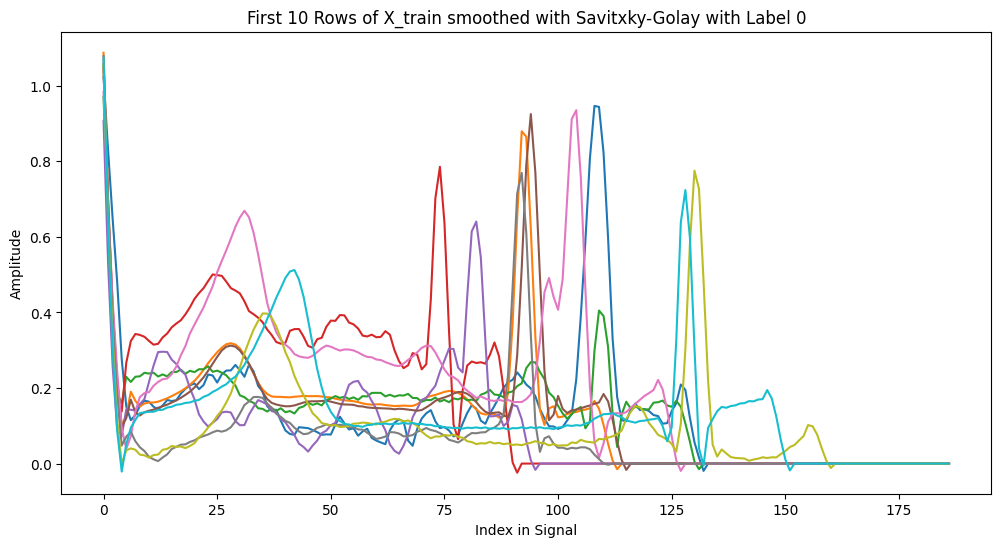

In [49]:
indices_label_0 = np.where(y_train_balanced == 0)[0]  
indices_label_0 = indices_label_0[:10]

plt.figure(figsize=(12, 6))
for idx in indices_label_0:
    plt.plot(X_train_savitzkygolay[idx])  

plt.title("First 10 Rows of X_train smoothed with Savitxky-Golay with Label 0")
plt.xlabel("Index in Signal")
plt.ylabel("Amplitude")
plt.show()

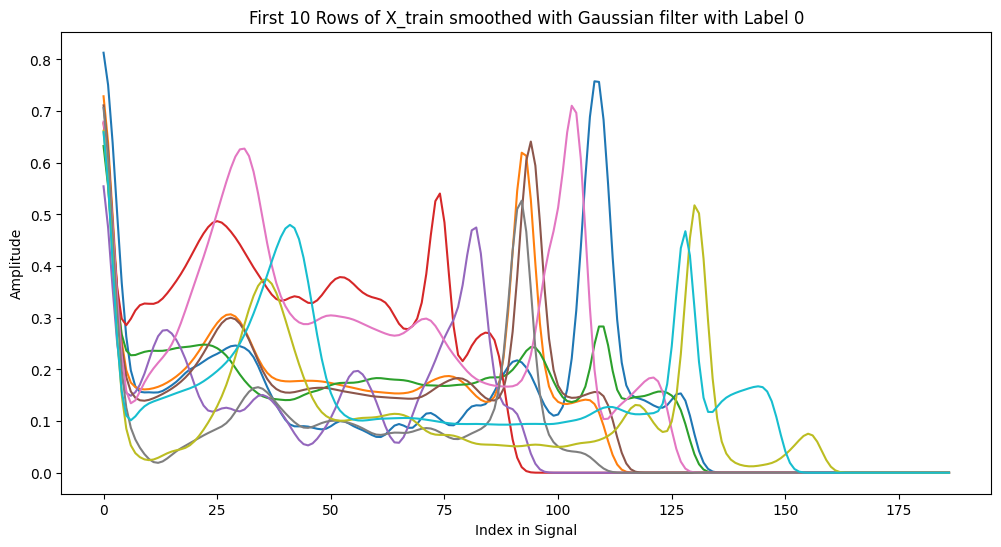

In [50]:
indices_label_0 = np.where(y_train_balanced == 0)[0]  
indices_label_0 = indices_label_0[:10]

plt.figure(figsize=(12, 6))
for idx in indices_label_0:
    plt.plot(X_train_gaussian[idx])  

plt.title("First 10 Rows of X_train smoothed with Gaussian filter with Label 0")
plt.xlabel("Index in Signal")
plt.ylabel("Amplitude")
plt.show()

In [19]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)

y_train_balanced_reshaped = y_train_balanced.reshape(-1, 1)
y_test_balanced_reshaped = y_test_balanced.reshape(-1, 1)

y_train_onehotencoded = encoder.fit_transform(y_train_balanced_reshaped)
y_test_onehotencoded = encoder.transform(y_test_balanced_reshaped)

In [20]:
from sklearn.model_selection import train_test_split
cnn_X_train_split, cnn_X_val_split, cnn_y_train_split, cnn_y_val_split = train_test_split(X_train_gaussian, y_train_onehotencoded, test_size=0.2, random_state=42)

[I 2025-03-21 11:06:25,694] A new study created in memory with name: no-name-fa2ba59f-5fc6-4ac8-ae84-df2fa36ec1b2
C:\Users\Roy\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - accuracy: 0.8475 - loss: 0.4343 - val_accuracy: 0.9519 - val_loss: 0.1428
Epoch 2/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - accuracy: 0.9494 - loss: 0.1493 - val_accuracy: 0.9666 - val_loss: 0.0950
Epoch 3/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 39s 21ms/step - accuracy: 0.9655 - loss: 0.1033 - val_accuracy: 0.9745 - val_loss: 0.0736
Epoch 4/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 39s 21ms/step - accuracy: 0.9739 - loss: 0.0760 - val_accuracy: 0.9769 - val_loss: 0.0689
Epoch 5/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - accuracy: 0.9770 - loss: 0.0657 - val_accuracy: 0.9847 - val_loss: 0.0456
Epoch 6/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - accuracy: 0.9805 - loss: 0.0544 - val_accuracy: 0.9864 - val_loss: 0.0447
Epoch 7/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - accuracy: 0.9839 - loss: 0.0469 - val_accuracy: 0.9862 - val_loss: 0.0417
Epoch 8/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 37s 19ms/step - accuracy: 0.9865 -

[I 2025-03-21 11:20:37,308] Trial 0 finished with value: 0.9921000003814697 and parameters: {'conv1_filters': 96, 'conv2_filters': 192, 'conv3_filters': 160, 'fc_units': 192, 'dropout_rate': 0.30000000000000004, 'lr': 0.002001163273888588, 'batch_size': 64}. Best is trial 0 with value: 0.9921000003814697.


Epoch 1/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 118s 31ms/step - accuracy: 0.8378 - loss: 0.4640 - val_accuracy: 0.9458 - val_loss: 0.1581
Epoch 2/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 116s 31ms/step - accuracy: 0.9453 - loss: 0.1587 - val_accuracy: 0.9658 - val_loss: 0.0966
Epoch 3/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 115s 31ms/step - accuracy: 0.9613 - loss: 0.1128 - val_accuracy: 0.9760 - val_loss: 0.0723
Epoch 4/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 115s 31ms/step - accuracy: 0.9708 - loss: 0.0848 - val_accuracy: 0.9807 - val_loss: 0.0587
Epoch 5/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 115s 31ms/step - accuracy: 0.9766 - loss: 0.0678 - val_accuracy: 0.9812 - val_loss: 0.0550
Epoch 6/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 115s 31ms/step - accuracy: 0.9797 - loss: 0.0588 - val_accuracy: 0.9818 - val_loss: 0.0529
Epoch 7/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 115s 31ms/step - accuracy: 0.9822 - loss: 0.0509 - val_accuracy: 0.9865 - val_loss: 0.0411
Epoch 8/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 115s 31ms/step - accuracy: 

[I 2025-03-21 12:08:52,038] Trial 1 finished with value: 0.9930999875068665 and parameters: {'conv1_filters': 128, 'conv2_filters': 256, 'conv3_filters': 512, 'fc_units': 192, 'dropout_rate': 0.4, 'lr': 0.00042161876444509746, 'batch_size': 32}. Best is trial 1 with value: 0.9930999875068665.


Epoch 1/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 31s 16ms/step - accuracy: 0.8386 - loss: 0.4650 - val_accuracy: 0.9495 - val_loss: 0.1378
Epoch 2/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - accuracy: 0.9370 - loss: 0.1822 - val_accuracy: 0.9657 - val_loss: 0.0989
Epoch 3/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - accuracy: 0.9531 - loss: 0.1369 - val_accuracy: 0.9696 - val_loss: 0.0840
Epoch 4/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - accuracy: 0.9607 - loss: 0.1118 - val_accuracy: 0.9770 - val_loss: 0.0675
Epoch 5/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - accuracy: 0.9668 - loss: 0.0950 - val_accuracy: 0.9823 - val_loss: 0.0523
Epoch 6/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - accuracy: 0.9715 - loss: 0.0826 - val_accuracy: 0.9831 - val_loss: 0.0524
Epoch 7/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - accuracy: 0.9750 - loss: 0.0721 - val_accuracy: 0.9833 - val_loss: 0.0519
Epoch 8/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - accuracy: 0.9771 -

[I 2025-03-21 12:21:22,184] Trial 2 finished with value: 0.9908666610717773 and parameters: {'conv1_filters': 96, 'conv2_filters': 96, 'conv3_filters': 256, 'fc_units': 128, 'dropout_rate': 0.5, 'lr': 0.003220137597930203, 'batch_size': 64}. Best is trial 1 with value: 0.9930999875068665.


Epoch 1/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.8105 - loss: 0.5288 - val_accuracy: 0.9365 - val_loss: 0.1899
Epoch 2/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - accuracy: 0.9298 - loss: 0.2089 - val_accuracy: 0.9513 - val_loss: 0.1354
Epoch 3/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - accuracy: 0.9446 - loss: 0.1625 - val_accuracy: 0.9609 - val_loss: 0.1079
Epoch 4/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - accuracy: 0.9554 - loss: 0.1290 - val_accuracy: 0.9625 - val_loss: 0.1042
Epoch 5/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 46s 12ms/step - accuracy: 0.9623 - loss: 0.1100 - val_accuracy: 0.9749 - val_loss: 0.0791
Epoch 6/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 48s 13ms/step - accuracy: 0.9667 - loss: 0.0961 - val_accuracy: 0.9749 - val_loss: 0.0755
Epoch 7/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 49s 13ms/step - accuracy: 0.9697 - loss: 0.0857 - val_accuracy: 0.9775 - val_loss: 0.0662
Epoch 8/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 49s 13ms/step - accuracy: 0.9740 -

[I 2025-03-21 12:39:18,209] Trial 3 finished with value: 0.9917666912078857 and parameters: {'conv1_filters': 32, 'conv2_filters': 96, 'conv3_filters': 416, 'fc_units': 64, 'dropout_rate': 0.2, 'lr': 0.0003974236077433237, 'batch_size': 32}. Best is trial 1 with value: 0.9930999875068665.


Epoch 1/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 54s 14ms/step - accuracy: 0.8638 - loss: 0.3929 - val_accuracy: 0.9563 - val_loss: 0.1205
Epoch 2/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 53s 14ms/step - accuracy: 0.9542 - loss: 0.1316 - val_accuracy: 0.9749 - val_loss: 0.0716
Epoch 3/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 53s 14ms/step - accuracy: 0.9685 - loss: 0.0919 - val_accuracy: 0.9789 - val_loss: 0.0608
Epoch 4/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 53s 14ms/step - accuracy: 0.9753 - loss: 0.0727 - val_accuracy: 0.9788 - val_loss: 0.0655
Epoch 5/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 54s 14ms/step - accuracy: 0.9793 - loss: 0.0614 - val_accuracy: 0.9818 - val_loss: 0.0554
Epoch 6/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 53s 14ms/step - accuracy: 0.9829 - loss: 0.0499 - val_accuracy: 0.9853 - val_loss: 0.0483
Epoch 7/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 53s 14ms/step - accuracy: 0.9843 - loss: 0.0465 - val_accuracy: 0.9874 - val_loss: 0.0416
Epoch 8/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 53s 14ms/step - accuracy: 0.9858 -

[I 2025-03-21 12:56:08,971] Trial 4 finished with value: 0.989466667175293 and parameters: {'conv1_filters': 64, 'conv2_filters': 192, 'conv3_filters': 192, 'fc_units': 224, 'dropout_rate': 0.30000000000000004, 'lr': 0.0025518712552222785, 'batch_size': 32}. Best is trial 1 with value: 0.9930999875068665.


Epoch 1/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 58s 15ms/step - accuracy: 0.8639 - loss: 0.3904 - val_accuracy: 0.9527 - val_loss: 0.1389
Epoch 2/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 57s 15ms/step - accuracy: 0.9542 - loss: 0.1324 - val_accuracy: 0.9641 - val_loss: 0.1028
Epoch 3/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 58s 15ms/step - accuracy: 0.9661 - loss: 0.0998 - val_accuracy: 0.9748 - val_loss: 0.0740
Epoch 4/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 59s 16ms/step - accuracy: 0.9721 - loss: 0.0787 - val_accuracy: 0.9769 - val_loss: 0.0692
Epoch 5/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 59s 16ms/step - accuracy: 0.9767 - loss: 0.0670 - val_accuracy: 0.9798 - val_loss: 0.0621
Epoch 6/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 59s 16ms/step - accuracy: 0.9784 - loss: 0.0615 - val_accuracy: 0.9804 - val_loss: 0.0591
Epoch 7/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 59s 16ms/step - accuracy: 0.9811 - loss: 0.0539 - val_accuracy: 0.9822 - val_loss: 0.0531
Epoch 8/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 59s 16ms/step - accuracy: 0.9828 -

[I 2025-03-21 13:19:49,355] Trial 5 finished with value: 0.9890333414077759 and parameters: {'conv1_filters': 32, 'conv2_filters': 160, 'conv3_filters': 384, 'fc_units': 128, 'dropout_rate': 0.1, 'lr': 0.003735051278957047, 'batch_size': 32}. Best is trial 1 with value: 0.9930999875068665.


Epoch 1/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 43s 22ms/step - accuracy: 0.8337 - loss: 0.4785 - val_accuracy: 0.9477 - val_loss: 0.1526
Epoch 2/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.9421 - loss: 0.1685 - val_accuracy: 0.9668 - val_loss: 0.0944
Epoch 3/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 42s 22ms/step - accuracy: 0.9582 - loss: 0.1204 - val_accuracy: 0.9750 - val_loss: 0.0756
Epoch 4/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.9664 - loss: 0.0969 - val_accuracy: 0.9752 - val_loss: 0.0736
Epoch 5/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.9723 - loss: 0.0789 - val_accuracy: 0.9814 - val_loss: 0.0574
Epoch 6/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.9761 - loss: 0.0679 - val_accuracy: 0.9805 - val_loss: 0.0558
Epoch 7/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.9781 - loss: 0.0621 - val_accuracy: 0.9830 - val_loss: 0.0528
Epoch 8/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.9817 -

[I 2025-03-21 13:36:22,318] Trial 6 finished with value: 0.991599977016449 and parameters: {'conv1_filters': 128, 'conv2_filters': 160, 'conv3_filters': 256, 'fc_units': 96, 'dropout_rate': 0.30000000000000004, 'lr': 0.0013220793786172449, 'batch_size': 64}. Best is trial 1 with value: 0.9930999875068665.


Epoch 1/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - accuracy: 0.8346 - loss: 0.4761 - val_accuracy: 0.9379 - val_loss: 0.1659
Epoch 2/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.9375 - loss: 0.1840 - val_accuracy: 0.9668 - val_loss: 0.0956
Epoch 3/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.9530 - loss: 0.1366 - val_accuracy: 0.9681 - val_loss: 0.0937
Epoch 4/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.9608 - loss: 0.1127 - val_accuracy: 0.9769 - val_loss: 0.0653
Epoch 5/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.9659 - loss: 0.0965 - val_accuracy: 0.9788 - val_loss: 0.0624
Epoch 6/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.9682 - loss: 0.0896 - val_accuracy: 0.9799 - val_loss: 0.0583
Epoch 7/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.9703 - loss: 0.0819 - val_accuracy: 0.9836 - val_loss: 0.0516
Epoch 8/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.9733 -

[I 2025-03-21 13:46:10,207] Trial 7 finished with value: 0.9910333156585693 and parameters: {'conv1_filters': 32, 'conv2_filters': 192, 'conv3_filters': 128, 'fc_units': 128, 'dropout_rate': 0.5, 'lr': 0.0028621211752832536, 'batch_size': 64}. Best is trial 1 with value: 0.9930999875068665.


Epoch 1/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 43s 22ms/step - accuracy: 0.8228 - loss: 0.5012 - val_accuracy: 0.9314 - val_loss: 0.1921
Epoch 2/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.9388 - loss: 0.1807 - val_accuracy: 0.9615 - val_loss: 0.1081
Epoch 3/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.9561 - loss: 0.1315 - val_accuracy: 0.9736 - val_loss: 0.0768
Epoch 4/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.9659 - loss: 0.0996 - val_accuracy: 0.9757 - val_loss: 0.0704
Epoch 5/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.9712 - loss: 0.0834 - val_accuracy: 0.9820 - val_loss: 0.0534
Epoch 6/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.9748 - loss: 0.0712 - val_accuracy: 0.9835 - val_loss: 0.0489
Epoch 7/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.9784 - loss: 0.0622 - val_accuracy: 0.9856 - val_loss: 0.0464
Epoch 8/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.9807 -

[I 2025-03-21 14:03:31,698] Trial 8 finished with value: 0.9927999973297119 and parameters: {'conv1_filters': 64, 'conv2_filters': 160, 'conv3_filters': 320, 'fc_units': 160, 'dropout_rate': 0.4, 'lr': 0.0006821847192687085, 'batch_size': 64}. Best is trial 1 with value: 0.9930999875068665.


Epoch 1/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 38s 10ms/step - accuracy: 0.7378 - loss: 0.7334 - val_accuracy: 0.9087 - val_loss: 0.2742
Epoch 2/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 36s 10ms/step - accuracy: 0.8922 - loss: 0.3317 - val_accuracy: 0.9285 - val_loss: 0.2099
Epoch 3/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 36s 10ms/step - accuracy: 0.9124 - loss: 0.2649 - val_accuracy: 0.9391 - val_loss: 0.1771
Epoch 4/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 36s 10ms/step - accuracy: 0.9240 - loss: 0.2258 - val_accuracy: 0.9488 - val_loss: 0.1508
Epoch 5/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 36s 10ms/step - accuracy: 0.9302 - loss: 0.2054 - val_accuracy: 0.9544 - val_loss: 0.1300
Epoch 6/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - accuracy: 0.9382 - loss: 0.1819 - val_accuracy: 0.9574 - val_loss: 0.1216
Epoch 7/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 38s 10ms/step - accuracy: 0.9426 - loss: 0.1686 - val_accuracy: 0.9607 - val_loss: 0.1111
Epoch 8/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - accuracy: 0.9456 -

[I 2025-03-21 14:18:50,411] Trial 9 finished with value: 0.9845666885375977 and parameters: {'conv1_filters': 96, 'conv2_filters': 160, 'conv3_filters': 160, 'fc_units': 96, 'dropout_rate': 0.5, 'lr': 0.00012119087189287228, 'batch_size': 32}. Best is trial 1 with value: 0.9930999875068665.


Epoch 1/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 133s 35ms/step - accuracy: 0.8226 - loss: 0.5053 - val_accuracy: 0.9422 - val_loss: 0.1686
Epoch 2/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 131s 35ms/step - accuracy: 0.9416 - loss: 0.1714 - val_accuracy: 0.9648 - val_loss: 0.1040
Epoch 3/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 130s 35ms/step - accuracy: 0.9594 - loss: 0.1204 - val_accuracy: 0.9692 - val_loss: 0.0873
Epoch 4/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 130s 35ms/step - accuracy: 0.9692 - loss: 0.0898 - val_accuracy: 0.9789 - val_loss: 0.0614
Epoch 5/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 131s 35ms/step - accuracy: 0.9756 - loss: 0.0744 - val_accuracy: 0.9809 - val_loss: 0.0575
Epoch 6/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 130s 35ms/step - accuracy: 0.9788 - loss: 0.0612 - val_accuracy: 0.9827 - val_loss: 0.0524
Epoch 7/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 132s 35ms/step - accuracy: 0.9820 - loss: 0.0532 - val_accuracy: 0.9852 - val_loss: 0.0459
Epoch 8/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 131s 35ms/step - accuracy: 

[I 2025-03-21 15:13:31,526] Trial 10 finished with value: 0.9927999973297119 and parameters: {'conv1_filters': 128, 'conv2_filters': 256, 'conv3_filters': 512, 'fc_units': 256, 'dropout_rate': 0.4, 'lr': 0.0002062958955607165, 'batch_size': 32}. Best is trial 1 with value: 0.9930999875068665.


Epoch 1/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 84s 44ms/step - accuracy: 0.8222 - loss: 0.5062 - val_accuracy: 0.9448 - val_loss: 0.1637
Epoch 2/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 81s 43ms/step - accuracy: 0.9399 - loss: 0.1797 - val_accuracy: 0.9623 - val_loss: 0.1121
Epoch 3/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 81s 43ms/step - accuracy: 0.9568 - loss: 0.1256 - val_accuracy: 0.9699 - val_loss: 0.0863
Epoch 4/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 81s 43ms/step - accuracy: 0.9659 - loss: 0.0983 - val_accuracy: 0.9767 - val_loss: 0.0679
Epoch 5/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - accuracy: 0.9732 - loss: 0.0786 - val_accuracy: 0.9806 - val_loss: 0.0568
Epoch 6/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 43ms/step - accuracy: 0.9761 - loss: 0.0675 - val_accuracy: 0.9851 - val_loss: 0.0472
Epoch 7/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 43ms/step - accuracy: 0.9803 - loss: 0.0580 - val_accuracy: 0.9837 - val_loss: 0.0532
Epoch 8/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 81s 43ms/step - accuracy: 0.9817 -

[I 2025-03-21 15:47:38,750] Trial 11 finished with value: 0.9929333329200745 and parameters: {'conv1_filters': 64, 'conv2_filters': 256, 'conv3_filters': 512, 'fc_units': 192, 'dropout_rate': 0.4, 'lr': 0.0004951580774008529, 'batch_size': 64}. Best is trial 1 with value: 0.9930999875068665.


Epoch 1/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 84s 44ms/step - accuracy: 0.8314 - loss: 0.4798 - val_accuracy: 0.9530 - val_loss: 0.1448
Epoch 2/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - accuracy: 0.9433 - loss: 0.1669 - val_accuracy: 0.9645 - val_loss: 0.1012
Epoch 3/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 43ms/step - accuracy: 0.9602 - loss: 0.1162 - val_accuracy: 0.9751 - val_loss: 0.0724
Epoch 4/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - accuracy: 0.9687 - loss: 0.0901 - val_accuracy: 0.9781 - val_loss: 0.0612
Epoch 5/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - accuracy: 0.9744 - loss: 0.0727 - val_accuracy: 0.9828 - val_loss: 0.0509
Epoch 6/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 43ms/step - accuracy: 0.9780 - loss: 0.0626 - val_accuracy: 0.9852 - val_loss: 0.0437
Epoch 7/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - accuracy: 0.9815 - loss: 0.0518 - val_accuracy: 0.9866 - val_loss: 0.0400
Epoch 8/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 43ms/step - accuracy: 0.9839 -

[I 2025-03-21 16:21:47,240] Trial 12 finished with value: 0.9935666918754578 and parameters: {'conv1_filters': 64, 'conv2_filters': 256, 'conv3_filters': 512, 'fc_units': 192, 'dropout_rate': 0.4, 'lr': 0.0005348767995137022, 'batch_size': 64}. Best is trial 12 with value: 0.9935666918754578.


Epoch 1/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 110s 29ms/step - accuracy: 0.8387 - loss: 0.4788 - val_accuracy: 0.9370 - val_loss: 0.1869
Epoch 2/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 107s 29ms/step - accuracy: 0.9238 - loss: 0.2256 - val_accuracy: 0.9415 - val_loss: 0.1781
Epoch 3/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 107s 28ms/step - accuracy: 0.9348 - loss: 0.1964 - val_accuracy: 0.9473 - val_loss: 0.1494
Epoch 4/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 108s 29ms/step - accuracy: 0.9383 - loss: 0.1832 - val_accuracy: 0.9457 - val_loss: 0.1576
Epoch 5/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 108s 29ms/step - accuracy: 0.9434 - loss: 0.1681 - val_accuracy: 0.9599 - val_loss: 0.1259
Epoch 6/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 109s 29ms/step - accuracy: 0.9467 - loss: 0.1610 - val_accuracy: 0.9608 - val_loss: 0.1288
Epoch 7/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 109s 29ms/step - accuracy: 0.9478 - loss: 0.1534 - val_accuracy: 0.9613 - val_loss: 0.1093
Epoch 8/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 108s 29ms/step - accuracy: 

[I 2025-03-21 17:06:55,995] Trial 13 finished with value: 0.9747666716575623 and parameters: {'conv1_filters': 128, 'conv2_filters': 256, 'conv3_filters': 448, 'fc_units': 192, 'dropout_rate': 0.4, 'lr': 0.008544913312356326, 'batch_size': 32}. Best is trial 12 with value: 0.9935666918754578.


Epoch 1/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 85s 44ms/step - accuracy: 0.8159 - loss: 0.5257 - val_accuracy: 0.9399 - val_loss: 0.1841
Epoch 2/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - accuracy: 0.9391 - loss: 0.1795 - val_accuracy: 0.9562 - val_loss: 0.1267
Epoch 3/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - accuracy: 0.9565 - loss: 0.1274 - val_accuracy: 0.9708 - val_loss: 0.0860
Epoch 4/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - accuracy: 0.9699 - loss: 0.0907 - val_accuracy: 0.9744 - val_loss: 0.0788
Epoch 5/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - accuracy: 0.9761 - loss: 0.0727 - val_accuracy: 0.9796 - val_loss: 0.0625
Epoch 6/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - accuracy: 0.9815 - loss: 0.0561 - val_accuracy: 0.9817 - val_loss: 0.0559
Epoch 7/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - accuracy: 0.9827 - loss: 0.0505 - val_accuracy: 0.9832 - val_loss: 0.0496
Epoch 8/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - accuracy: 0.9857 -

[I 2025-03-21 17:41:27,763] Trial 14 finished with value: 0.9918666481971741 and parameters: {'conv1_filters': 96, 'conv2_filters': 224, 'conv3_filters': 480, 'fc_units': 256, 'dropout_rate': 0.2, 'lr': 0.00026036470179261823, 'batch_size': 64}. Best is trial 12 with value: 0.9935666918754578.


Epoch 1/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 84s 22ms/step - accuracy: 0.8502 - loss: 0.4260 - val_accuracy: 0.9536 - val_loss: 0.1335
Epoch 2/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 82s 22ms/step - accuracy: 0.9520 - loss: 0.1413 - val_accuracy: 0.9727 - val_loss: 0.0777
Epoch 3/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 83s 22ms/step - accuracy: 0.9663 - loss: 0.0982 - val_accuracy: 0.9777 - val_loss: 0.0642
Epoch 4/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 82s 22ms/step - accuracy: 0.9737 - loss: 0.0757 - val_accuracy: 0.9830 - val_loss: 0.0493
Epoch 5/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 83s 22ms/step - accuracy: 0.9792 - loss: 0.0597 - val_accuracy: 0.9842 - val_loss: 0.0475
Epoch 6/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 82s 22ms/step - accuracy: 0.9818 - loss: 0.0532 - val_accuracy: 0.9868 - val_loss: 0.0413
Epoch 7/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 83s 22ms/step - accuracy: 0.9852 - loss: 0.0429 - val_accuracy: 0.9890 - val_loss: 0.0358
Epoch 8/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 83s 22ms/step - accuracy: 0.9860 -

[I 2025-03-21 18:12:09,836] Trial 15 finished with value: 0.9923999905586243 and parameters: {'conv1_filters': 64, 'conv2_filters': 224, 'conv3_filters': 352, 'fc_units': 224, 'dropout_rate': 0.4, 'lr': 0.0009903797573282368, 'batch_size': 32}. Best is trial 12 with value: 0.9935666918754578.


Epoch 1/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 48s 25ms/step - accuracy: 0.7966 - loss: 0.5632 - val_accuracy: 0.9342 - val_loss: 0.1972
Epoch 2/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 46s 25ms/step - accuracy: 0.9303 - loss: 0.2097 - val_accuracy: 0.9502 - val_loss: 0.1469
Epoch 3/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 47s 25ms/step - accuracy: 0.9470 - loss: 0.1554 - val_accuracy: 0.9640 - val_loss: 0.1078
Epoch 4/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 46s 25ms/step - accuracy: 0.9579 - loss: 0.1248 - val_accuracy: 0.9708 - val_loss: 0.0863
Epoch 5/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 46s 25ms/step - accuracy: 0.9663 - loss: 0.0992 - val_accuracy: 0.9780 - val_loss: 0.0698
Epoch 6/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 46s 25ms/step - accuracy: 0.9737 - loss: 0.0791 - val_accuracy: 0.9792 - val_loss: 0.0656
Epoch 7/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 48s 25ms/step - accuracy: 0.9770 - loss: 0.0705 - val_accuracy: 0.9813 - val_loss: 0.0575
Epoch 8/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 47s 25ms/step - accuracy: 0.9802 -

[I 2025-03-21 18:31:45,240] Trial 16 finished with value: 0.9908666610717773 and parameters: {'conv1_filters': 128, 'conv2_filters': 64, 'conv3_filters': 448, 'fc_units': 160, 'dropout_rate': 0.2, 'lr': 0.00032798802723597284, 'batch_size': 64}. Best is trial 12 with value: 0.9935666918754578.


Epoch 1/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 118s 31ms/step - accuracy: 0.7800 - loss: 0.6298 - val_accuracy: 0.9256 - val_loss: 0.2251
Epoch 2/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 116s 31ms/step - accuracy: 0.9143 - loss: 0.2570 - val_accuracy: 0.9431 - val_loss: 0.1690
Epoch 3/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 115s 31ms/step - accuracy: 0.9336 - loss: 0.1971 - val_accuracy: 0.9529 - val_loss: 0.1340
Epoch 4/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 115s 31ms/step - accuracy: 0.9451 - loss: 0.1640 - val_accuracy: 0.9602 - val_loss: 0.1176
Epoch 5/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 116s 31ms/step - accuracy: 0.9521 - loss: 0.1416 - val_accuracy: 0.9664 - val_loss: 0.0981
Epoch 6/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 118s 31ms/step - accuracy: 0.9562 - loss: 0.1292 - val_accuracy: 0.9704 - val_loss: 0.0870
Epoch 7/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 119s 32ms/step - accuracy: 0.9603 - loss: 0.1158 - val_accuracy: 0.9745 - val_loss: 0.0758
Epoch 8/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 119s 32ms/step - accuracy: 

[I 2025-03-21 19:20:59,118] Trial 17 finished with value: 0.989466667175293 and parameters: {'conv1_filters': 96, 'conv2_filters': 224, 'conv3_filters': 512, 'fc_units': 224, 'dropout_rate': 0.5, 'lr': 0.00010280120899465803, 'batch_size': 32}. Best is trial 12 with value: 0.9935666918754578.


Epoch 1/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 75s 39ms/step - accuracy: 0.8326 - loss: 0.4771 - val_accuracy: 0.9416 - val_loss: 0.1700
Epoch 2/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 72s 38ms/step - accuracy: 0.9424 - loss: 0.1724 - val_accuracy: 0.9645 - val_loss: 0.1008
Epoch 3/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 70s 37ms/step - accuracy: 0.9598 - loss: 0.1174 - val_accuracy: 0.9734 - val_loss: 0.0776
Epoch 4/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 70s 37ms/step - accuracy: 0.9689 - loss: 0.0884 - val_accuracy: 0.9780 - val_loss: 0.0657
Epoch 5/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 70s 37ms/step - accuracy: 0.9748 - loss: 0.0735 - val_accuracy: 0.9846 - val_loss: 0.0486
Epoch 6/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 71s 38ms/step - accuracy: 0.9777 - loss: 0.0639 - val_accuracy: 0.9832 - val_loss: 0.0507
Epoch 7/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 70s 37ms/step - accuracy: 0.9806 - loss: 0.0556 - val_accuracy: 0.9864 - val_loss: 0.0427
Epoch 8/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 70s 37ms/step - accuracy: 0.9824 -

[I 2025-03-21 19:50:50,710] Trial 18 finished with value: 0.993066668510437 and parameters: {'conv1_filters': 64, 'conv2_filters': 256, 'conv3_filters': 448, 'fc_units': 160, 'dropout_rate': 0.4, 'lr': 0.0007427209878336132, 'batch_size': 64}. Best is trial 12 with value: 0.9935666918754578.


Epoch 1/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 73s 19ms/step - accuracy: 0.8410 - loss: 0.4580 - val_accuracy: 0.9400 - val_loss: 0.1695
Epoch 2/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 72s 19ms/step - accuracy: 0.9483 - loss: 0.1556 - val_accuracy: 0.9596 - val_loss: 0.1138
Epoch 3/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 72s 19ms/step - accuracy: 0.9641 - loss: 0.1055 - val_accuracy: 0.9740 - val_loss: 0.0755
Epoch 4/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 72s 19ms/step - accuracy: 0.9729 - loss: 0.0780 - val_accuracy: 0.9793 - val_loss: 0.0605
Epoch 5/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 72s 19ms/step - accuracy: 0.9772 - loss: 0.0652 - val_accuracy: 0.9780 - val_loss: 0.0610
Epoch 6/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 72s 19ms/step - accuracy: 0.9812 - loss: 0.0538 - val_accuracy: 0.9864 - val_loss: 0.0415
Epoch 7/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 70s 19ms/step - accuracy: 0.9834 - loss: 0.0487 - val_accuracy: 0.9865 - val_loss: 0.0402
Epoch 8/25
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 69s 18ms/step - accuracy: 0.9853 -

[I 2025-03-21 20:20:25,693] Trial 19 finished with value: 0.9930333495140076 and parameters: {'conv1_filters': 32, 'conv2_filters': 224, 'conv3_filters': 320, 'fc_units': 192, 'dropout_rate': 0.30000000000000004, 'lr': 0.0005408123025047761, 'batch_size': 32}. Best is trial 12 with value: 0.9935666918754578.



Best Hyperparameters: {'conv1_filters': 64, 'conv2_filters': 256, 'conv3_filters': 512, 'fc_units': 192, 'dropout_rate': 0.4, 'lr': 0.0005348767995137022, 'batch_size': 64}
Epoch 1/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 88s 46ms/step - accuracy: 0.8232 - loss: 0.5039 - val_accuracy: 0.9449 - val_loss: 0.1622
Epoch 2/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 83s 44ms/step - accuracy: 0.9416 - loss: 0.1759 - val_accuracy: 0.9617 - val_loss: 0.1100
Epoch 3/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 84s 45ms/step - accuracy: 0.9576 - loss: 0.1238 - val_accuracy: 0.9691 - val_loss: 0.0804
Epoch 4/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 84s 45ms/step - accuracy: 0.9662 - loss: 0.0974 - val_accuracy: 0.9794 - val_loss: 0.0613
Epoch 5/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 84s 45ms/step - accuracy: 0.9728 - loss: 0.0785 - val_accuracy: 0.9796 - val_loss: 0.0606
Epoch 6/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 85s 45ms/step - accuracy: 0.9760 - loss: 0.0685 - val_accuracy: 0.9836 - val_loss: 0.0481
Epoch 7/50
1875/1875 ━━━━━━━━━━━━━

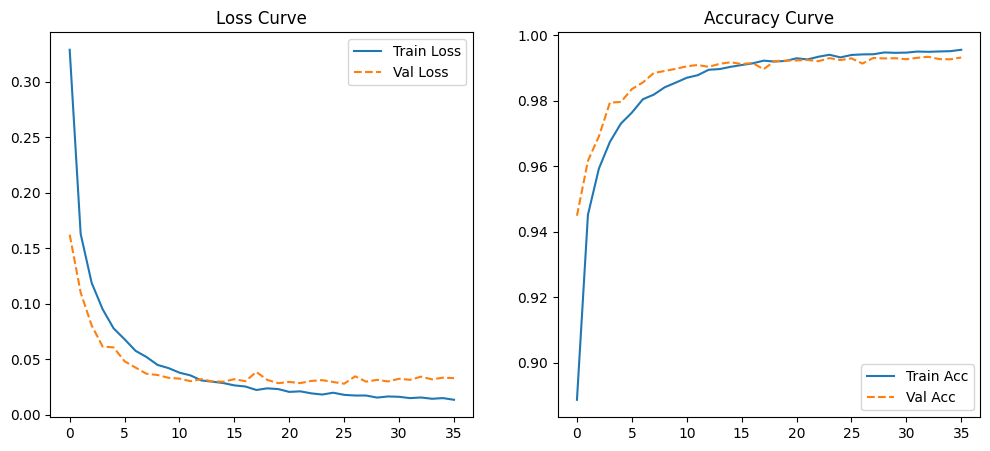

In [21]:
import tensorflow as tf
import optuna
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping

def create_model(input_dim, num_classes, conv1_filters, conv2_filters, conv3_filters, fc_units, dropout_rate, lr):
    model = Sequential([
        Conv1D(filters=conv1_filters, kernel_size=3, activation='relu', padding='same', input_shape=(input_dim, 1)),
        MaxPooling1D(pool_size=2),
        
        Conv1D(filters=conv2_filters, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        
        Conv1D(filters=conv3_filters, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        
        Flatten(),
        Dense(fc_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=lr), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

def objective(trial):
    conv1_filters = trial.suggest_int("conv1_filters", 32, 128, step=32)
    conv2_filters = trial.suggest_int("conv2_filters", 64, 256, step=32)
    conv3_filters = trial.suggest_int("conv3_filters", 128, 512, step=32)
    fc_units = trial.suggest_int("fc_units", 64, 256, step=32)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64])

    # Create model
    model = create_model(187, 5, conv1_filters, conv2_filters, conv3_filters, fc_units, dropout_rate, lr)

    # Train model
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(cnn_X_train_split, cnn_y_train_split, 
                        validation_data=(cnn_X_val_split, cnn_y_val_split), 
                        epochs=25, batch_size=batch_size, 
                        verbose=1, callbacks=[early_stopping])
    
    # Get best validation accuracy
    val_acc = max(history.history["val_accuracy"])
    
    return val_acc

# Hyperparameter tuning
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
best_params = study.best_params
print("\nBest Hyperparameters:", best_params)

# Train Final Model with Best Hyperparameters
best_model = create_model(187, 5, best_params["conv1_filters"], best_params["conv2_filters"], 
                          best_params["conv3_filters"], best_params["fc_units"], best_params["dropout_rate"], best_params["lr"])

batch_size = best_params["batch_size"]
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = best_model.fit(cnn_X_train_split, cnn_y_train_split, 
                         validation_data=(cnn_X_val_split, cnn_y_val_split), 
                         epochs=50, batch_size=batch_size, 
                         verbose=1, callbacks=[early_stopping])

# Plot loss & accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss", linestyle="dashed")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc", linestyle="dashed")
plt.legend()
plt.title("Accuracy Curve")
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step

Test Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.99      0.95      2000
         1.0       0.97      0.90      0.94      2000
         2.0       0.92      0.95      0.93      2000
         3.0       0.97      0.91      0.94      2000
         4.0       0.98      0.99      0.99      2000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



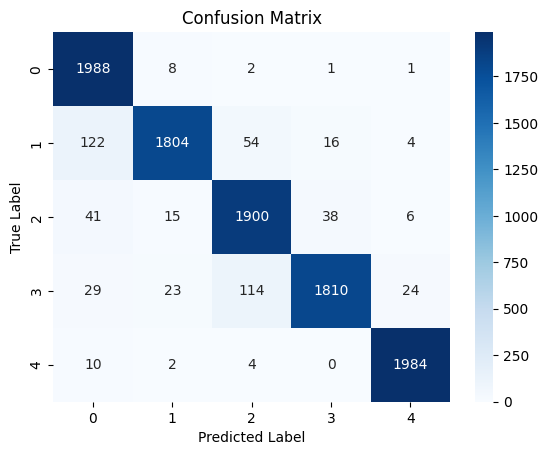

In [51]:
# Evaluate Model
test_preds = best_model.predict(X_test_gaussian).argmax(axis=1)
test_labels = y_test_balanced

print("\nTest Classification Report:\n", classification_report(test_labels, test_preds))
sns.heatmap(confusion_matrix(test_labels, test_preds), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [25]:
best_model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_60 (Conv1D)                   │ (None, 187, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_60 (MaxPooling1D)      │ (None, 93, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_61 (Conv1D)                   │ (None, 93, 256)             │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_61 (MaxPooling1D)      │ (None, 46, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_62 (Conv1D)                   │ (None, 46, 512)             │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_62 (MaxPooling1D)      │ (None, 23, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_20 (Flatten)                 │ (None, 11776)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 192)                 │       2,261,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 5)                   │             965 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,116,625 (30.96 MB)

 Trainable params: 2,705,541 (10.32 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,411,084 (20.64 MB)

### RNN-LSTM

C:\Users\Roy\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.4897 - loss: 1.2307  

3750/3750 ━━━━━━━━━━━━━━━━━━━━ 380s 100ms/step - accuracy: 0.4897 - loss: 1.2306 - val_accuracy: 0.7363 - val_loss: 0.7761 - learning_rate: 0.0010
Epoch 2/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8434 - loss: 0.4588  

3750/3750 ━━━━━━━━━━━━━━━━━━━━ 380s 101ms/step - accuracy: 0.8434 - loss: 0.4588 - val_accuracy: 0.8657 - val_loss: 0.4183 - learning_rate: 0.0010
Epoch 3/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8974 - loss: 0.3254  

3750/3750 ━━━━━━━━━━━━━━━━━━━━ 383s 102ms/step - accuracy: 0.8974 - loss: 0.3253 - val_accuracy: 0.9118 - val_loss: 0.2773 - learning_rate: 0.0010
Epoch 4/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9314 - loss: 0.2162  

3750/3750 ━━━━━━━━━━━━━━━━━━━━ 375s 100ms/step - accuracy: 0.9314 - loss: 0.2162 - val_accuracy: 0.9406 - val_loss: 0.1747 - learning_rate: 0.0010
Epoch 5/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9435 - loss: 0.1746  

3750/3750 ━━━━━━━━━━━━━━━━━━━━ 382s 102ms/step - accuracy: 0.9435 - loss: 0.1746 - val_accuracy: 0.9553 - val_loss: 0.1473 - learning_rate: 0.0010
Epoch 6/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 381s 102ms/step - accuracy: 0.9516 - loss: 0.1527 - val_accuracy: 0.9488 - val_loss: 0.1533 - learning_rate: 0.0010
Epoch 7/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9582 - loss: 0.1334  

3750/3750 ━━━━━━━━━━━━━━━━━━━━ 387s 103ms/step - accuracy: 0.9582 - loss: 0.1334 - val_accuracy: 0.9634 - val_loss: 0.1121 - learning_rate: 0.0010
Epoch 8/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9615 - loss: 0.1218  

3750/3750 ━━━━━━━━━━━━━━━━━━━━ 380s 101ms/step - accuracy: 0.9615 - loss: 0.1218 - val_accuracy: 0.9644 - val_loss: 0.1091 - learning_rate: 0.0010
Epoch 9/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9634 - loss: 0.1132  

3750/3750 ━━━━━━━━━━━━━━━━━━━━ 383s 102ms/step - accuracy: 0.9634 - loss: 0.1132 - val_accuracy: 0.9734 - val_loss: 0.0806 - learning_rate: 0.0010
Epoch 10/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 390s 104ms/step - accuracy: 0.9682 - loss: 0.0999 - val_accuracy: 0.9729 - val_loss: 0.0833 - learning_rate: 0.0010
Epoch 11/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 396s 106ms/step - accuracy: 0.9710 - loss: 0.0907 - val_accuracy: 0.9734 - val_loss: 0.0858 - learning_rate: 0.0010
Epoch 12/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9736 - loss: 0.0846  

3750/3750 ━━━━━━━━━━━━━━━━━━━━ 394s 105ms/step - accuracy: 0.9736 - loss: 0.0846 - val_accuracy: 0.9787 - val_loss: 0.0684 - learning_rate: 0.0010
Epoch 13/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9744 - loss: 0.0807  

3750/3750 ━━━━━━━━━━━━━━━━━━━━ 384s 103ms/step - accuracy: 0.9744 - loss: 0.0807 - val_accuracy: 0.9800 - val_loss: 0.0626 - learning_rate: 0.0010
Epoch 14/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9745 - loss: 0.0814  

3750/3750 ━━━━━━━━━━━━━━━━━━━━ 387s 103ms/step - accuracy: 0.9745 - loss: 0.0814 - val_accuracy: 0.9806 - val_loss: 0.0624 - learning_rate: 0.0010
Epoch 15/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 389s 104ms/step - accuracy: 0.9776 - loss: 0.0724 - val_accuracy: 0.9792 - val_loss: 0.0658 - learning_rate: 0.0010
Epoch 16/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 392s 104ms/step - accuracy: 0.9783 - loss: 0.0702 - val_accuracy: 0.9795 - val_loss: 0.0646 - learning_rate: 0.0010
Epoch 17/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9782 - loss: 0.0700  

3750/3750 ━━━━━━━━━━━━━━━━━━━━ 393s 105ms/step - accuracy: 0.9782 - loss: 0.0700 - val_accuracy: 0.9851 - val_loss: 0.0481 - learning_rate: 0.0010
Epoch 18/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 393s 105ms/step - accuracy: 0.9796 - loss: 0.0643 - val_accuracy: 0.9829 - val_loss: 0.0539 - learning_rate: 0.0010
Epoch 19/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 396s 106ms/step - accuracy: 0.9806 - loss: 0.0637 - val_accuracy: 0.9827 - val_loss: 0.0564 - learning_rate: 0.0010
Epoch 20/20
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9813 - loss: 0.0603  

3750/3750 ━━━━━━━━━━━━━━━━━━━━ 397s 106ms/step - accuracy: 0.9813 - loss: 0.0603 - val_accuracy: 0.9847 - val_loss: 0.0459 - learning_rate: 0.0010


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                       │ (None, 187, 128)            │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 187, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 187, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 350,417 (1.34 MB)

 Trainable params: 116,677 (455.77 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 233,356 (911.55 KB)

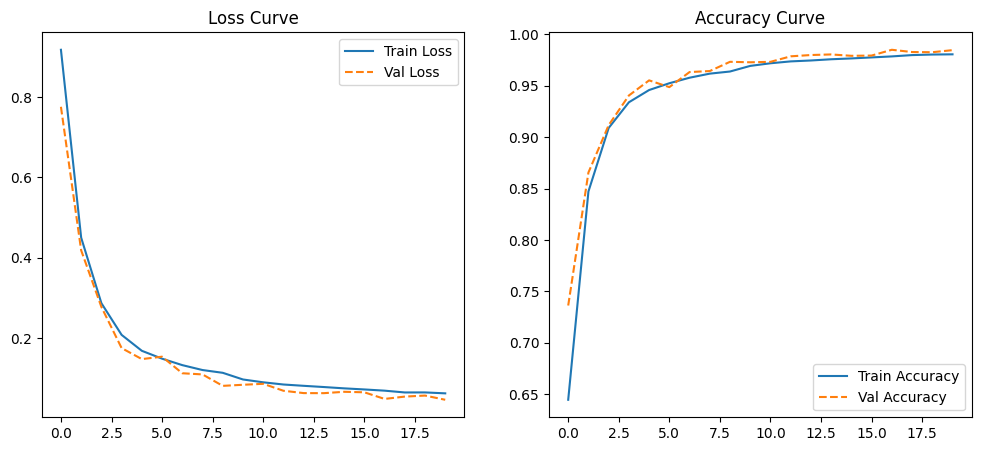

In [39]:
from tensorflow.keras.layers import LSTM, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau

def build_lstm_model(input_shape, num_classes, lstm_units1=128, lstm_units2=64, dropout_rate=0.2, lr=1e-3):
    model = Sequential([
        LSTM(lstm_units1, input_shape=input_shape, return_sequences=True),
        BatchNormalization(),
        Dropout(dropout_rate),

        LSTM(lstm_units2),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='categorical_crossentropy',  
                  metrics=['accuracy'])

    return model

# Model parameters
input_shape = (cnn_X_train_split.shape[1], 1) 
num_classes = 5  

# Build and compile the model
lstm_model = build_lstm_model(input_shape, num_classes)

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_lstm_model.h5', save_best_only=True, monitor='val_loss')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the LSTM model
lstm_history = lstm_model.fit(cnn_X_train_split, cnn_y_train_split,
                              epochs=20,
                              batch_size=32,
                              validation_data=(cnn_X_val_split, cnn_y_val_split),
                              callbacks=[reduce_lr, model_checkpoint, early_stopping])

# Print model summary
lstm_model.summary()

# ---- Plot Training History ----
plt.figure(figsize=(12,5))

# Plot loss
plt.subplot(1,2,1)
plt.plot(lstm_history.history['loss'], label="Train Loss")
plt.plot(lstm_history.history['val_loss'], label="Val Loss", linestyle="dashed")
plt.legend()
plt.title("Loss Curve")

# Plot accuracy
plt.subplot(1,2,2)
plt.plot(lstm_history.history['accuracy'], label="Train Accuracy")
plt.plot(lstm_history.history['val_accuracy'], label="Val Accuracy", linestyle="dashed")
plt.legend()
plt.title("Accuracy Curve")

plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step

Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.98      0.94      2000
         1.0       0.96      0.89      0.92      2000
         2.0       0.91      0.94      0.93      2000
         3.0       0.96      0.92      0.94      2000
         4.0       0.99      0.98      0.99      2000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



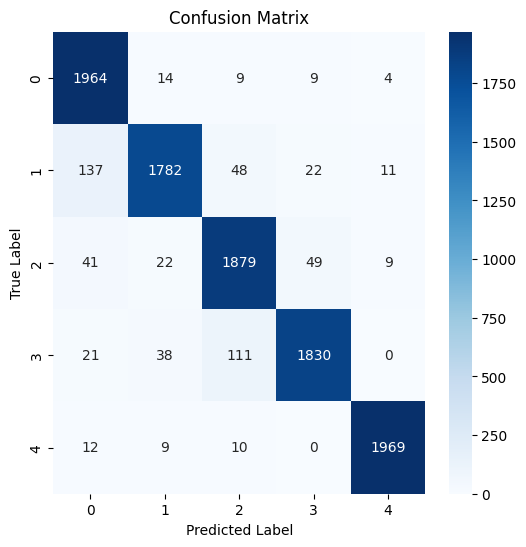

In [42]:
# ---- Model Evaluation ----
# Predict on test data
y_pred_probs = lstm_model.predict(X_test_gaussian)  
y_pred = np.argmax(y_pred_probs, axis=1)  
y_true =y_test_balanced  

# Print classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_66 (Conv1D)                   │ (None, 187, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_66 (MaxPooling1D)      │ (None, 93, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_67 (Conv1D)                   │ (None, 93, 256)             │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_67 (MaxPooling1D)      │ (None, 46, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_68 (Conv1D)                   │ (None, 46, 512)             │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_68 (MaxPooling1D)      │ (None, 23, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_22 (Flatten)                 │ (None, 11776)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 23, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_20 (LSTM)                       │ (None, 23, 128)             │         328,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 23, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_21 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 192)                 │          12,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_40 (Dropout)                 │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 5)                   │             965 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 834,437 (3.18 MB)

 Trainable params: 834,437 (3.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 223s 117ms/step - accuracy: 0.5965 - loss: 0.9935 - val_accuracy: 0.9103 - val_loss: 0.2950
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 215s 115ms/step - accuracy: 0.9107 - loss: 0.2807 - val_accuracy: 0.9448 - val_loss: 0.1609
Epoch 3/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 216s 115ms/step - accuracy: 0.9441 - loss: 0.1751 - val_accuracy: 0.9588 - val_loss: 0.1233
Epoch 4/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 217s 116ms/step - accuracy: 0.9584 - loss: 0.1266 - val_accuracy: 0.9644 - val_loss: 0.1051
Epoch 5/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 216s 115ms/step - accuracy: 0.9675 - loss: 0.1020 - val_accuracy: 0.9765 - val_loss: 0.0722
Epoch 6/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 215s 114ms/step - accuracy: 0.9725 - loss: 0.0865 - val_accuracy: 0.9793 - val_loss: 0.0635
Epoch 7/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 220s 117ms/step - accuracy: 0.9765 - loss: 0.0757 - val_accuracy: 0.9768 - val_loss: 0.0754
Epoch 8/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 219s 117ms/step - ac

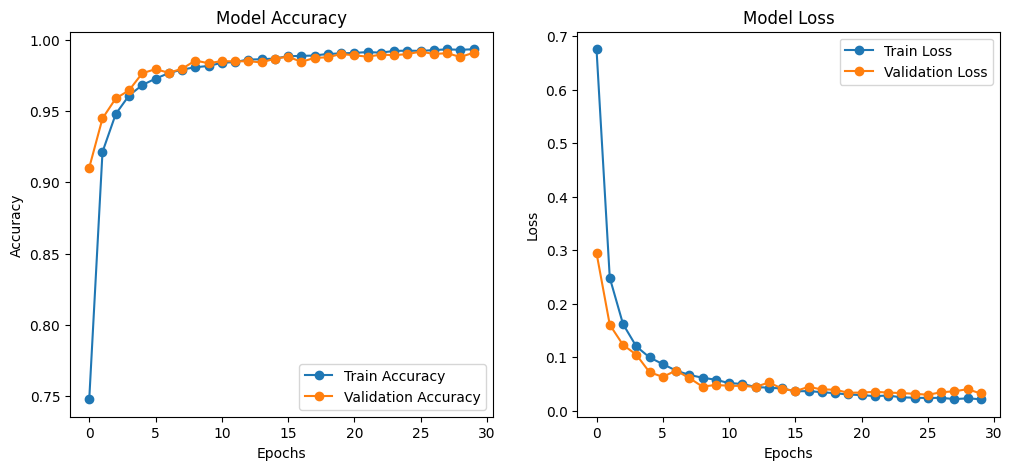

In [44]:
from tensorflow.keras.layers import Reshape
# CNN-LSTM Model
def build_cnn_lstm_model(input_shape, num_classes):
    model = Sequential([
        # CNN Feature Extractor
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        
        # Reshape for LSTM
        Flatten(),
        Reshape((input_shape[0] // 8, 512)),  

        # LSTM for Sequential Learning
        LSTM(128, return_sequences=True),
        Dropout(0.4),
        LSTM(64),
        Dropout(0.4),

        # Fully Connected Layers
        Dense(192, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])

    # Compile Model
    model.compile(optimizer=Adam(learning_rate=0.0005348767995137022), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Define input shape
input_shape = (187, 1)  
num_classes = 5  

# Initialize Model
cnn_lstm_model = build_cnn_lstm_model(input_shape, num_classes)
cnn_lstm_model.summary()

# Train Model
history = cnn_lstm_model.fit(cnn_X_train_split, cnn_y_train_split, 
                             validation_data=(cnn_X_val_split, cnn_y_val_split), 
                             epochs=30, batch_size=64, verbose=1)


# ---- Plot Accuracy & Loss ----
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step

Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.99      0.95      2000
         1.0       0.98      0.91      0.94      2000
         2.0       0.91      0.96      0.93      2000
         3.0       0.97      0.90      0.93      2000
         4.0       0.98      0.99      0.99      2000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



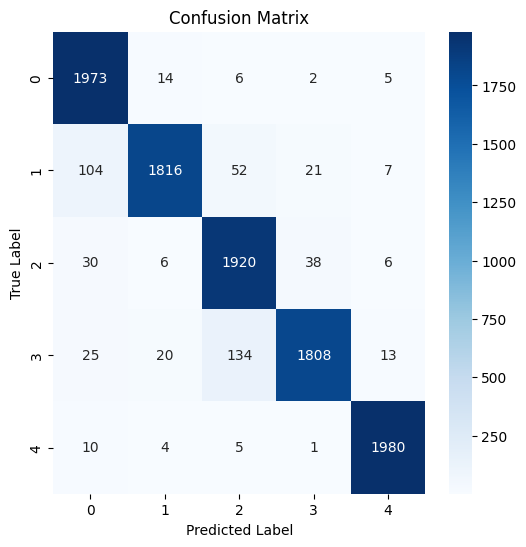

In [46]:
# ---- Model Evaluation ----
# Predict on test data
y_pred_probs = cnn_lstm_model.predict(X_test_gaussian)  
y_pred = np.argmax(y_pred_probs, axis=1)  
y_true = y_test_balanced  

# Print Classification Report
print("\nClassification Report:\n", classification_report(y_true, y_pred))

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()